In [1]:
import nevergrad as ng
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from pylab import rcParams

rcParams["figure.figsize"] = 18, 12
plt.rcParams.update({'font.size': 22})

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


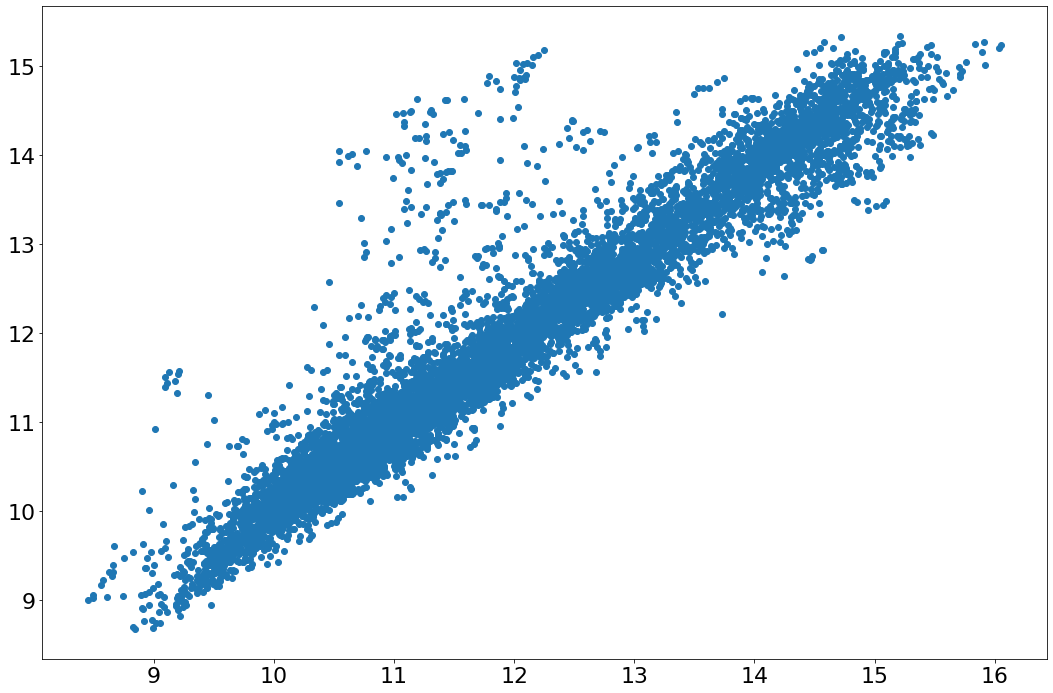

Time
2019-01-02 00:00:00     9.791285
2019-01-02 01:00:00     9.595427
2019-01-02 02:00:00     9.538146
2019-01-02 03:00:00     9.420105
2019-01-02 04:00:00     9.364424
                         ...    
2019-12-31 19:00:00    12.082850
2019-12-31 20:00:00    11.582850
2019-12-31 21:00:00    11.257850
2019-12-31 22:00:00    10.887850
2019-12-31 23:00:00    10.482850
Name: Fact, Length: 8736, dtype: float64

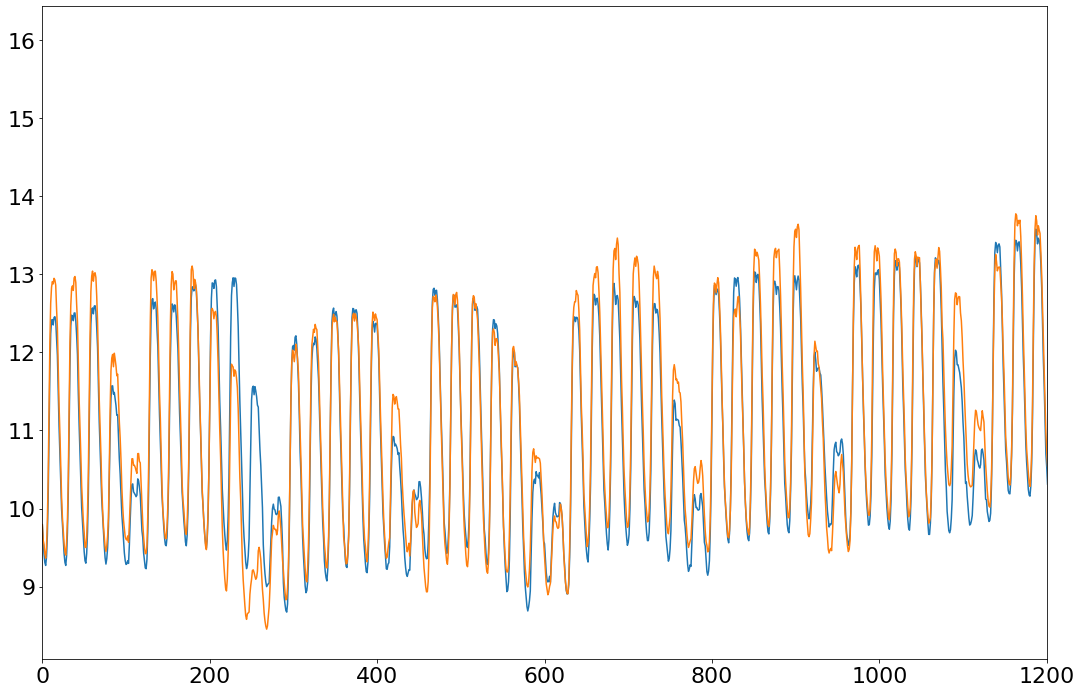

In [2]:
np.random.seed(0)

demand_data = 100000 * pd.read_csv("data/district/predictions_2019.csv", index_col=0, parse_dates=True) / 100000
# extra_prophet = pd.read_csv("data/district/extra_prophet_runs.csv", index_col=0, parse_dates=True) / 100000

# demand_data = demand_data.merge(extra_prophet, left_index=True, right_index=True)

actual = demand_data.Fact.values
prediction = demand_data['LR Model 120d'].values
# prediction = demand_data['CB Model'].values
# prediction = .4 * demand_data['Prophet 120d'].values + .4 * demand_data['LR Model 120d'].values + demand_data['CB Model 240d'].values * .15 + demand_data['SNaive'].values * .05
prediction = .25 * (demand_data['Prophet 30d'].values + demand_data['Prophet 60d'].values + demand_data['Prophet 120d'].values + demand_data['Prophet 240d'].values)
# demand_data['mean_CB'] = .25 * (demand_data['LR Model 30d'].values + demand_data['LR Model 60d'].values + demand_data['LR Model 120d'].values + demand_data['LR Model 240d'].values)
# demand_data['mean_LR'] = .25 * (demand_data['CB Model 30d'].values + demand_data['CB Model 60d'].values + demand_data['CB Model 120d'].values + demand_data['CB Model 240d'].values)
# demand_data['mean_Theta'] = .25 * (demand_data['Theta 30d'].values + demand_data['Theta 60d'].values + demand_data['Theta 120d'].values + demand_data['Theta 240d'].values)

demand_data['mean_prophet'] = .25 * (demand_data['Prophet 30d'].values + demand_data['Prophet 60d'].values + demand_data['Prophet 120d'].values + demand_data['Prophet 240d'].values)
demand_data['mean_LR'] = .25 * (demand_data['LR Model 30d'].values + demand_data['LR Model 60d'].values + demand_data['LR Model 120d'].values + demand_data['LR Model 240d'].values)
demand_data['mean_CB'] = .25 * (demand_data['CB Model 30d'].values + demand_data['CB Model 60d'].values + demand_data['CB Model 120d'].values + demand_data['CB Model 240d'].values)
demand_data['mean_Theta'] = .25 * (demand_data['Theta 30d'].values + demand_data['Theta 60d'].values + demand_data['Theta 120d'].values + demand_data['Theta 240d'].values)

demand_data['mean'] = .125 * (demand_data['Prophet 30d'].values + demand_data['Prophet 60d'].values + demand_data['Prophet 120d'].values + demand_data['Prophet 240d'].values) + .125 * (demand_data['LR Model 30d'].values + demand_data['LR Model 60d'].values + demand_data['LR Model 120d'].values + demand_data['LR Model 240d'].values)


rmae = np.zeros(23)
r2 = np.zeros(len(rmae))
for i in range(len(rmae)):
    prediction = demand_data.iloc[:,i]
    rmae[i] = (np.mean(np.abs(prediction-actual)) / np.mean(np.abs(demand_data.SNaive - actual)))
    r2[i] = (np.corrcoef(prediction,actual)[1][0]) ** 2
rmae = np.append(rmae, 0)

# prediction = .1 * (demand_data['Prophet 30d'].values + demand_data['Prophet 60d'].values + demand_data['Prophet 120d'].values + demand_data['Prophet 240d'].values) + .1 * (demand_data['LR Model 30d'].values + demand_data['LR Model 60d'].values + demand_data['LR Model 120d'].values + demand_data['LR Model 240d'].values) + .05 * (demand_data['CB Model 30d'].values + demand_data['CB Model 60d'].values + demand_data['CB Model 120d'].values + demand_data['CB Model 240d'].values)

prediction = .125 * (demand_data['Prophet 30d'].values + demand_data['Prophet 60d'].values + demand_data['Prophet 120d'].values + demand_data['Prophet 240d'].values) + .125 * (demand_data['LR Model 30d'].values + demand_data['LR Model 60d'].values + demand_data['LR Model 120d'].values + demand_data['LR Model 240d'].values)

# prediction = demand_data['SNaive'].values

# prediction = demand_data['Theta Model'].values
# prediction = demand_data['ensemble'].values
# prediction = demand_data['naive_weekly'].values

# prediction = actual + np.random.normal(0,.86,len(actual))*actual/10

plt.scatter(actual,prediction)
plt.show()

plt.plot(prediction)
plt.plot(actual)
plt.xlim(0,1200)

demand_data.iloc[:,16]

In [3]:
rmae

array([0.8627563 , 0.87359253, 0.80750342, 0.78573097, 0.82201568,
       0.79207377, 0.78797689, 0.80204903, 1.61184042, 1.60259863,
       1.59816103, 1.59001596, 0.84041567, 0.80221291, 0.81692408,
       0.82619988, 0.        , 1.        , 0.76356721, 0.79019394,
       0.81948807, 1.59924185, 0.71162303, 0.        ])

In [4]:
print(np.mean(np.abs(prediction-actual)) / np.mean(np.abs(demand_data.SNaive - actual)))

print(np.corrcoef(prediction,actual)[1][0]**2)


0.7116230255500808
0.9087502771391059


In [5]:
prediction

array([ 9.79387031,  9.59921855,  9.41924644, ..., 11.1096518 ,
       10.76892515, 10.43581717])

In [6]:
def cost_function_capacity_constraint_peak(individual):

    cumsum = np.cumsum(individual) + batteryCharge
    violations_battery = (np.sum(np.where(cumsum>batteryCapacity)) + np.sum(np.where(cumsum<0))) * 10000
    
    tmp = demand+individual
    violations_demand = -np.sum(tmp[np.where(tmp<0)]) * 10000
    
    peak_demand = np.max(demand + individual)
    violations_peak = - min(0, peakPowerLimit - peak_demand)*10000

    batteryUsage = (1 - battery_efficiency) * np.sum(np.abs(individual)) * 1000
    
    return violations_battery+violations_demand+violations_peak + batteryUsage,



In [7]:
def cost_function_capacity_constraint_margin(individual):

    cumsum = np.cumsum(individual) + batteryCharge
    violations_battery = (np.sum(np.where(cumsum>batteryCapacity)) + np.sum(np.where(cumsum<0))) * 10000
    
    tmp = demand+individual
    violations_demand = -np.sum(tmp[np.where(tmp<0)]) * 10000
    
    margin = (peakPowerLimit - (demand + individual))
    violations_peak = - np.sum(margin[np.where(margin < 0)]) * 1000

    batteryUsage = (1 - battery_efficiency) * np.sum(np.abs(individual)) * 1000
    
    return violations_battery + violations_demand + violations_peak + batteryUsage,



In [19]:
# Define constraints and other boiler plate code

batteryCapacity = 150 # kWh
inverterCapacity = 80 #kW
battery_efficiency = .9
peakPowerLimit = 12 # kW

compBudget = 5000
timeHorizon = 96
days = 60
costs = np.zeros((days))
actions = np.zeros((days,24))


# Capacity constraints

In [20]:
# Experimental code for random day selection

In [21]:
start=time.time()

batteryCharge = 0
par = ng.p.Array(shape=(timeHorizon,)).set_bounds(lower=-inverterCapacity, upper=inverterCapacity)
excess = np.zeros(23)

np.random.seed(0)
days = (np.random.uniform(0,350,days)).astype(int)
print(days)

for i in np.arange(0,1):#len(excess)):
    
    print(i)
    ctr = 0
    observed = []
    
#     for day in np.arange(0,days):
    for day in days:
        
        demand = demand_data.iloc[day*24:day*24+timeHorizon,i].values
#         demand = prediction[day*24:day*24+timeHorizon]
    #     demand = actual[day*24:day*24+timeHorizon]

        # Create optimal plan with prediction
        np.random.seed(0)
        optimizer = ng.optimizers.CMA(parametrization=par, budget=compBudget)
        recommendation = optimizer.minimize(cost_function_capacity_constraint_margin)  # best value

        # Execute optimal plan with actual demand

        demand = actual[day*24:day*24+timeHorizon]

        costs[ctr] = cost_function_capacity_constraint_margin(recommendation.value)[0]
        actions[ctr] = recommendation.value[0:24]

        batteryCharge = batteryCharge + np.cumsum(recommendation.value)[23]

#         print('Time taken and battery charge till day:', day, time.time() - start, batteryCharge)
        
        observed = np.append(observed, actual[day*24:day*24+24])
        
        ctr = ctr + 1
    
    forecaster_excess = peakPowerLimit - (actions.reshape(-1,) + observed)
    excess[i] = np.sum(forecaster_excess[np.where(forecaster_excess<0)])
#     print()

baseline = peakPowerLimit - observed
excess = np.append(excess,np.sum(baseline[np.where(baseline<0)]))

[192 250 210 190 148 226 153 312 337 134 277 185 198 323  24  30   7 291
 272 304 342 279 161 273  41 223  50 330 182 145  92 270 159 198   6 216
 214 215 330 238 125 152 244  21 233 234  73  45 110 127 199 153 345  35
  73  56 228  88 163  85]
0
(8_w,17)-aCMA-ES (mu_w=5.1,w_1=31%) in dimension 96 (seed=nan, Sat Dec 18 20:25:57 2021)
(8_w,17)-aCMA-ES (mu_w=5.1,w_1=31%) in dimension 96 (seed=nan, Sat Dec 18 20:26:02 2021)
(8_w,17)-aCMA-ES (mu_w=5.1,w_1=31%) in dimension 96 (seed=nan, Sat Dec 18 20:26:07 2021)
(8_w,17)-aCMA-ES (mu_w=5.1,w_1=31%) in dimension 96 (seed=nan, Sat Dec 18 20:26:11 2021)
(8_w,17)-aCMA-ES (mu_w=5.1,w_1=31%) in dimension 96 (seed=nan, Sat Dec 18 20:26:16 2021)
(8_w,17)-aCMA-ES (mu_w=5.1,w_1=31%) in dimension 96 (seed=nan, Sat Dec 18 20:26:21 2021)
(8_w,17)-aCMA-ES (mu_w=5.1,w_1=31%) in dimension 96 (seed=nan, Sat Dec 18 20:26:26 2021)
(8_w,17)-aCMA-ES (mu_w=5.1,w_1=31%) in dimension 96 (seed=nan, Sat Dec 18 20:26:31 2021)
(8_w,17)-aCMA-ES (mu_w=5.1,w_1=31%) in di

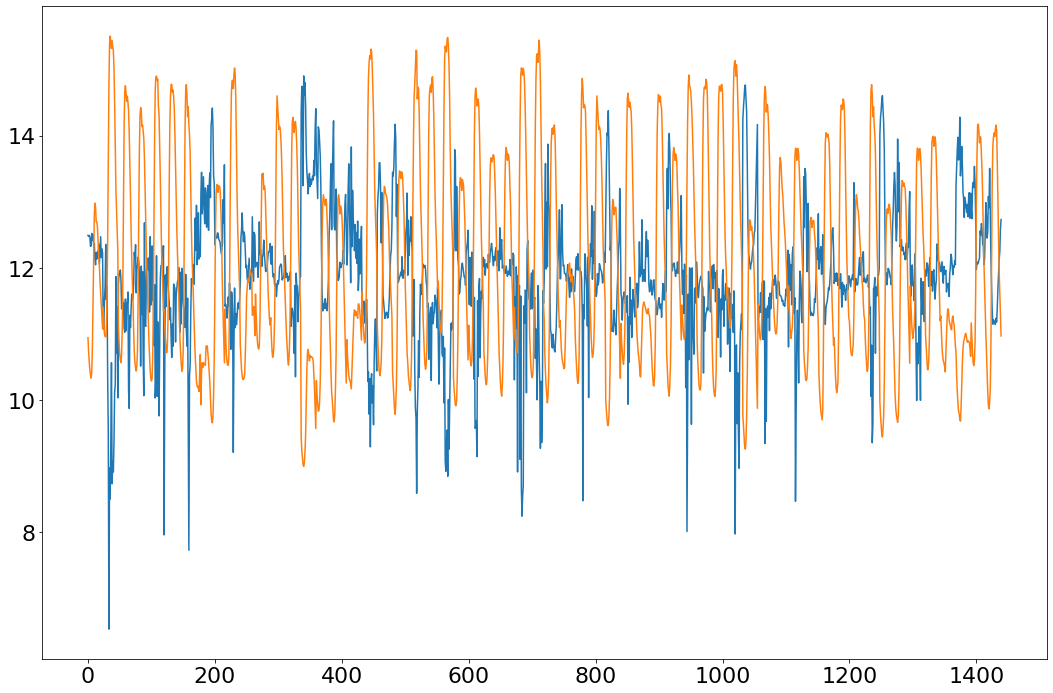

In [31]:
plt.plot(forecaster_excess + peakPowerLimit)
plt.plot(observed)

In [22]:
# rmae_excess = pd.read_csv('data/district/rmae_excess_15_08.csv',header=None).values
# rmae = rmae_excess[:,1]
# excess = rmae_excess[:,0]

excess
# rmae

array([ -583.49684233,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        , -1063.33651377])

In [23]:
rmae

array([0.8627563 , 0.87359253, 0.80750342, 0.78573097, 0.82201568,
       0.79207377, 0.78797689, 0.80204903, 1.61184042, 1.60259863,
       1.59816103, 1.59001596, 0.84041567, 0.80221291, 0.81692408,
       0.82619988, 0.        , 1.        , 0.76356721, 0.79019394,
       0.81948807, 1.59924185, 0.71162303, 0.        ])

In [24]:
excess

array([ -583.49684233,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        , -1063.33651377])

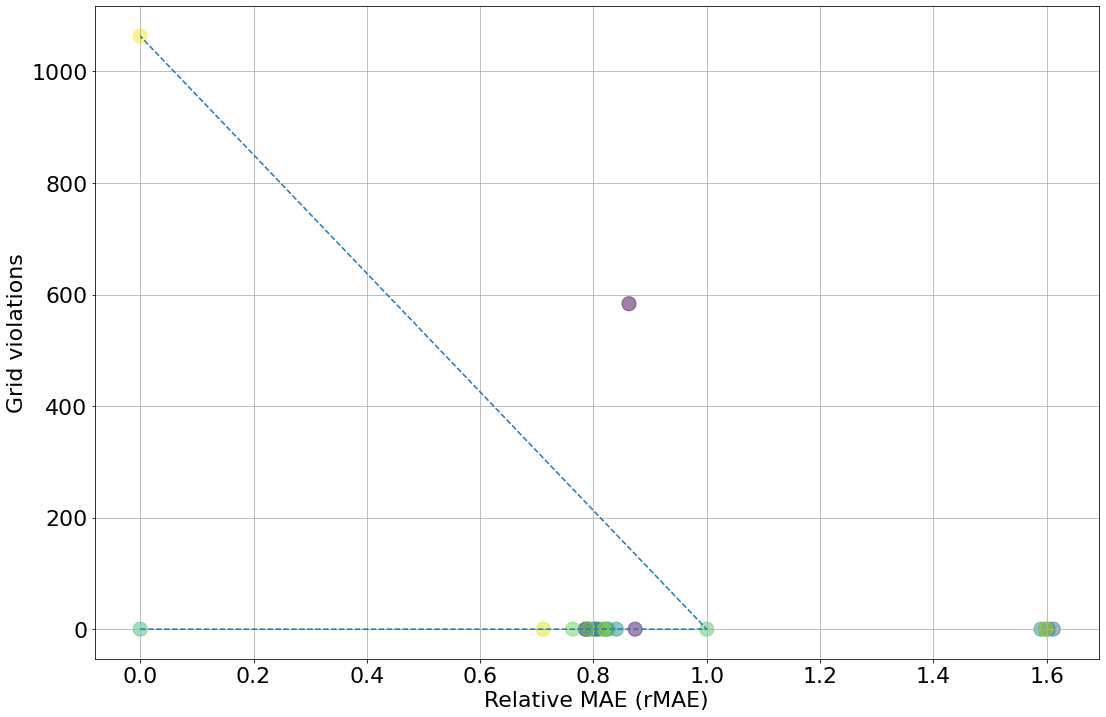

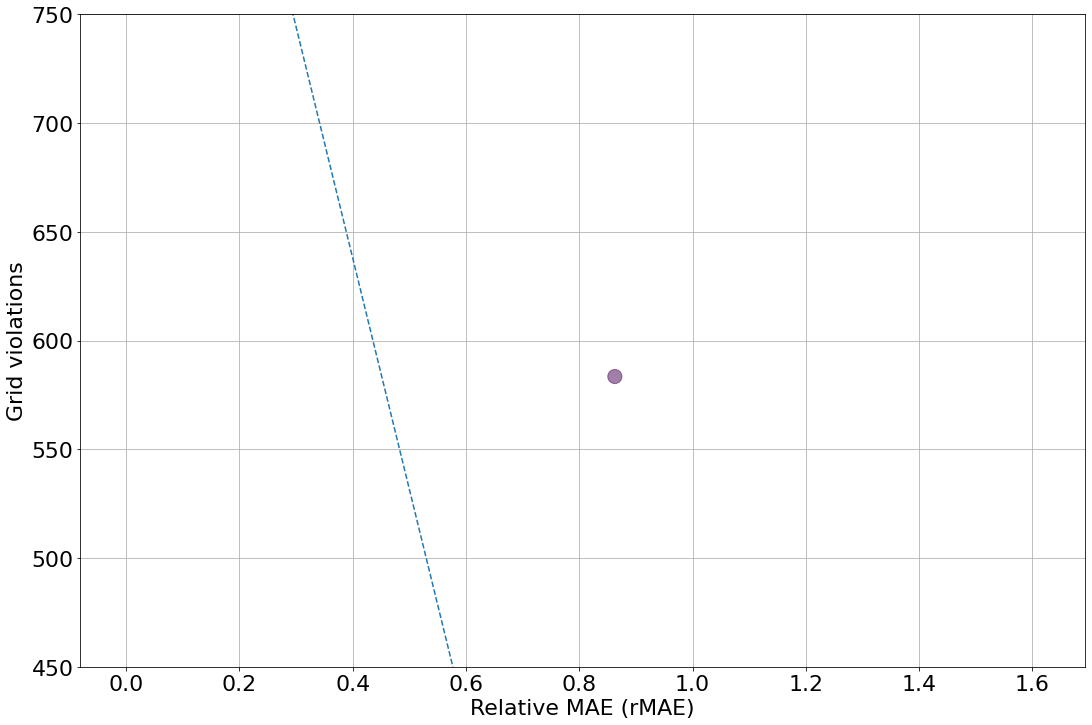

array([ -583.49684233,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        , -1063.33651377])

In [25]:
# idx = [131,132,133,134,0,1,2,3,100,101,102,103,241,242,243,244,40,50,0,1000,2000,3000,4000,5000]
# idx = [0,1,2,3,100,101,102,103,241,242,243,244,131,132,133,134,40,50]

idx = np.arange(0,2400,step=100)
# idx = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,5,6,6,6,6,6,7,7,7,7,8,8,8,8,9]

plt.scatter(rmae, -excess, s=200, alpha=.5, c=idx)
plt.plot(rmae[[16,17,-1]], -excess[[16,17,-1]], '--')
plt.xlabel('Relative MAE (rMAE)')
plt.ylabel('Grid violations')
plt.grid(True)
plt.show()

plt.scatter(rmae, -excess, s=200, alpha=.5, c=idx)
plt.plot(rmae[[16,17,-1]], -excess[[16,17,-1]], '--')
plt.ylim(450,750)
plt.xlabel('Relative MAE (rMAE)')
plt.ylabel('Grid violations')
plt.grid(True)
plt.show()

excess

In [15]:
df = pd.DataFrame(rmae,excess)
df.to_csv('data/district/rmae_excess_150_80.csv')

ValueError: Shape of passed values is (24, 1), indices imply (23, 1)

In [16]:
actual[day*24:day*24+24]

array([10.91285048, 10.67285048, 10.50785048, 10.37285048, 10.30785048,
       10.29785048, 10.23785048, 10.16785048, 10.44285048, 10.72785048,
       11.03785048, 11.27785048, 11.36285048, 11.27785048, 11.34285048,
       11.28785048, 11.27785048, 11.23785048, 11.45285048, 11.45285048,
       11.37285048, 11.26785048, 11.09285048, 10.90785048])

In [106]:
# Automate

In [ ]:
start=time.time()

batteryCharge = 0
par = ng.p.Array(shape=(timeHorizon,)).set_bounds(lower=-inverterCapacity, upper=inverterCapacity)
excess = np.zeros(18)

for i in np.arange(0,len(excess)):
    
    print(i)
    for day in np.arange(0,days):
        
        np.random.seed(0)
        
        demand = demand_data.iloc[day*24:day*24+timeHorizon,i].values
#         demand = prediction[day*24:day*24+timeHorizon]
    #     demand = actual[day*24:day*24+timeHorizon]

        # Create optimal plan with prediction
        optimizer = ng.optimizers.CMA(parametrization=par, budget=compBudget)
        recommendation = optimizer.minimize(cost_function_capacity_constraint_margin)  # best value

        # Execute optimal plan with actual demand

        demand = actual[day*24:day*24+timeHorizon]

        costs[day] = cost_function_capacity_constraint_margin(recommendation.value)[0]
        actions[day] = recommendation.value[0:24]

        batteryCharge = batteryCharge + np.cumsum(recommendation.value)[23]

        print('Time taken and battery charge till day:', day, time.time() - start, batteryCharge)
    
    forecaster_excess = peakPowerLimit - (actions.reshape(-1,) + actual[0:days*24])
    excess[i] = np.sum(forecaster_excess[np.where(forecaster_excess<0)])
    print()


array([ -6.28385026, -18.81211788,  -7.05554058,  -7.10615702,
       -13.41231366,  -6.82700385,  -8.96477712, -16.57396984,
       -13.10686781,  -9.73287022,  -7.72508943,  -7.74270267,
       -18.37126998, -19.00695691, -15.56253122, -16.04591718,
        -0.0297457 , -13.09386228, -22.01826622])

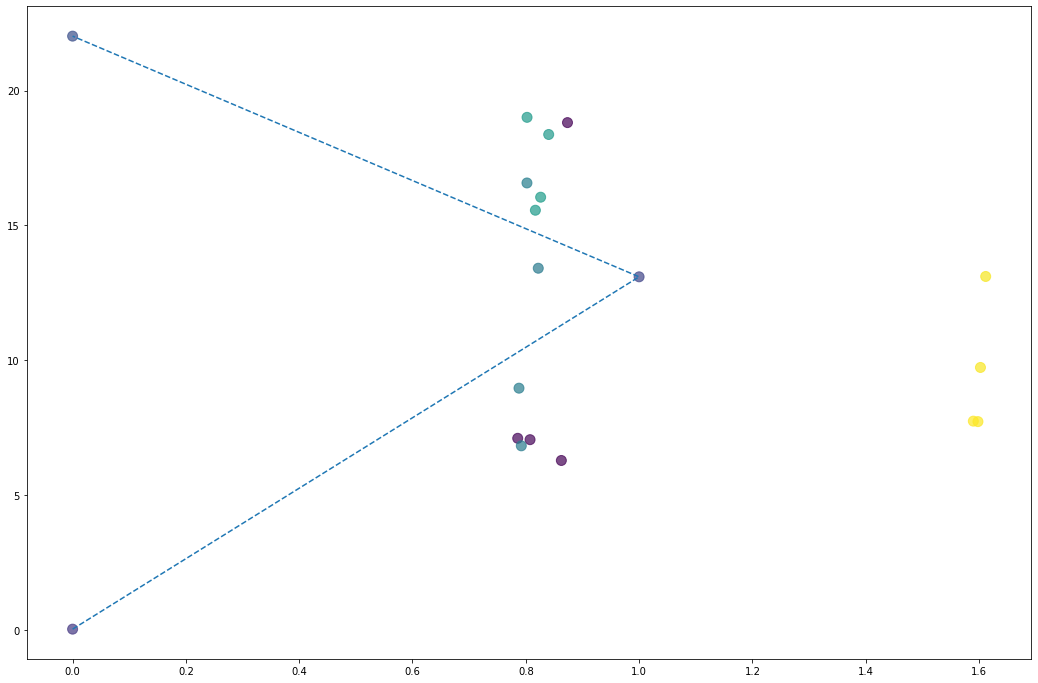

In [68]:
baseline = peakPowerLimit - (actual[0:days*24])
excess[-1] = np.sum(baseline[np.where(baseline<0)])

idx = [0,1,2,3,100,101,102,103,241,242,243,244,131,132,133,134,40,50,60]

plt.scatter(rmae,-excess,s=100,alpha=.7,c=idx)

plt.plot(rmae[-3:],-excess[-3:],'--')

excess

In [ ]:
# Working code

In [ ]:
start=time.time()

batteryCharge = 0
par = ng.p.Array(shape=(timeHorizon,)).set_bounds(lower=-inverterCapacity, upper=inverterCapacity)

for day in np.arange(0,days):
    
    np.random.seed(0)
    
    demand = prediction[day*24:day*24+timeHorizon]
#     demand = actual[day*24:day*24+timeHorizon]
    
    # Create optimal plan with prediction
    optimizer = ng.optimizers.CMA(parametrization=par, budget=compBudget)
    recommendation = optimizer.minimize(cost_function_capacity_constraint_margin)  # best value
    
    # Execute optimal plan with actual demand
    
    demand = actual[day*24:day*24+timeHorizon]
    
    costs[day] = cost_function_capacity_constraint_margin(recommendation.value)[0]
    actions[day] = recommendation.value[0:24]
    
    batteryCharge = batteryCharge + np.cumsum(recommendation.value)[23]

    print('Time taken and battery charge till day:', day, time.time() - start, batteryCharge)
#     print()
    

-2379.269668799934
-5394.3548040999995


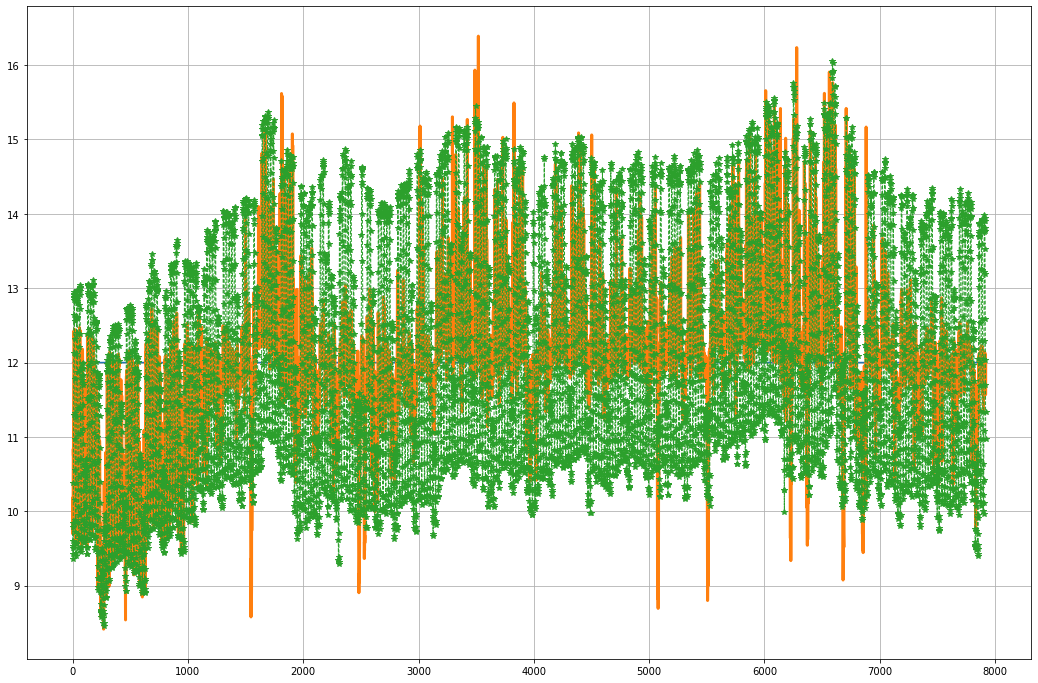

In [261]:
plt.plot([peakPowerLimit]*days*24)
plt.plot(actions.reshape(-1,)+actual[0:days*24],lw=3)
# plt.plot(actions.reshape(-1,),lw=1)
plt.plot(actual[0:days*24], '*--', lw=1)
plt.grid(True)

excess = peakPowerLimit - (actions.reshape(-1,) + actual[0:days*24])
print(np.sum(excess[np.where(excess<0)]))

excess = peakPowerLimit - (actual[0:days*24])
print(np.sum(excess[np.where(excess<0)]))


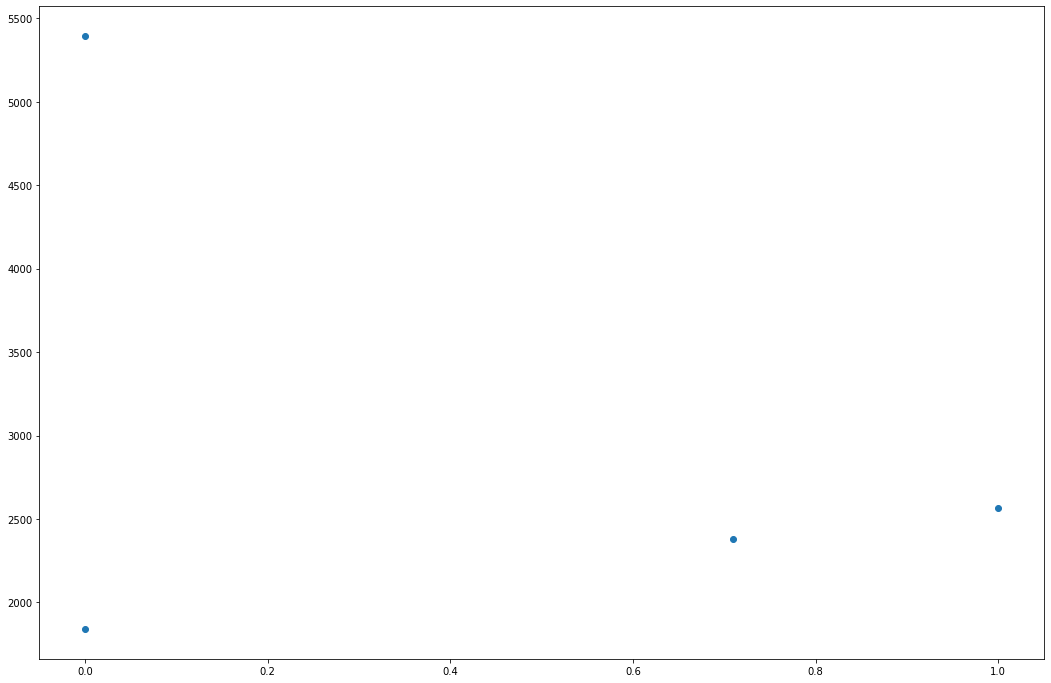

In [265]:
# 330 days - 12 limit, 75/40 battery
error = [0, 0, 1, 0.71]#, .76, .79, .82, 1.6]
cost = [5394, 1840, 2567, 2379]#, 35, 35, 47, 59]

plt.scatter(error,cost)

# 30 days - 12 limit, 75/40 battery
# error = [0, 0, 1, 0.71, .76, .79, .82, 1.6]
# cost = [115, 0, 54, 32, 35, 35, 47, 59]

# plt.scatter(error,cost)

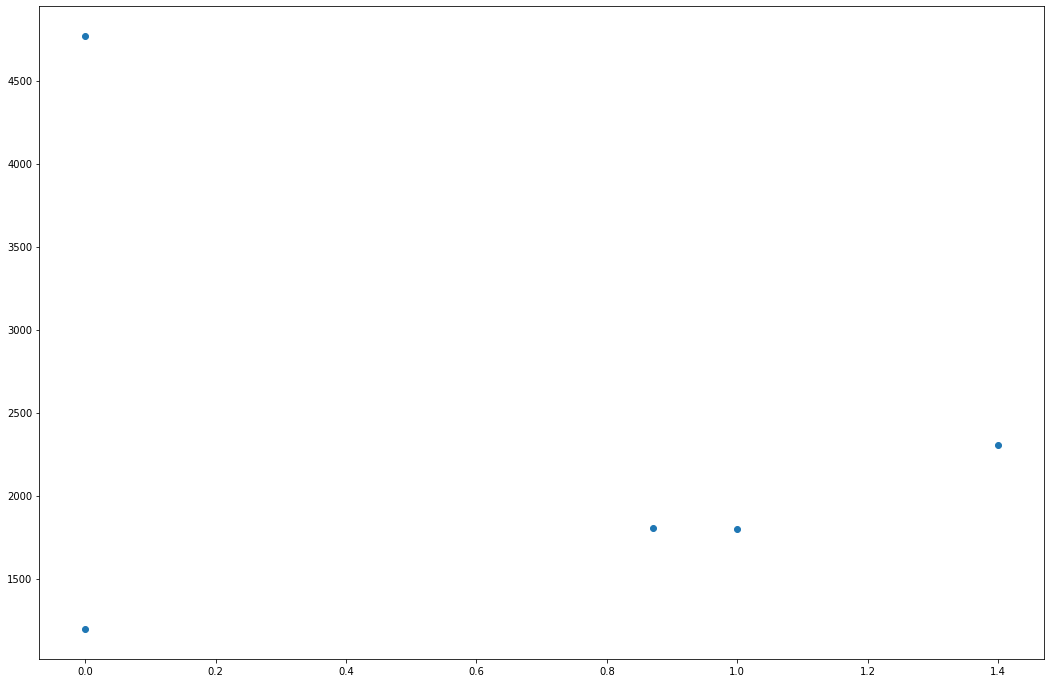

In [195]:
# 330 days - 12 limit, 750/400 battery
error = [0, 0, 1, 0.87, 1.4]
cost = [4769, 1195, 1797, 1806, 2302]

plt.scatter(error,cost)

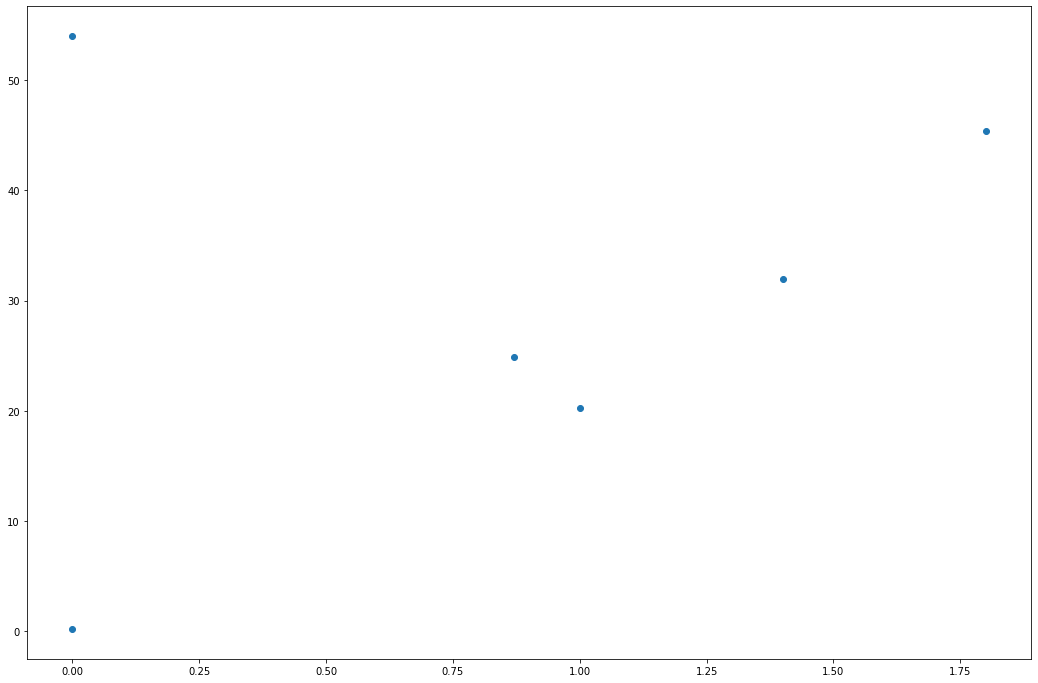

In [196]:
error = [0,0, 1,1.55,.8,.7,.85,1.45,1.11,2.1,2.1]
cost = [280,0,60,100,100,60,70,140,80,100,110]

cost = [54,0.2,20.3,24.9,45.4,32]
error = [0,0,1,.87,1.8,1.4]

plt.scatter(error,cost)

In [ ]:
stime = 1440

plt.plot([peakPowerLimit]*stime)
plt.plot(actions.reshape(-1,)+actual[0:stime],lw=3)
# plt.plot(actions.reshape(-1,),lw=1)
plt.plot(actual[0:stime], '*--', lw=1)
plt.grid(True)
plt.show()

plt.plot(np.cumsum(actions.reshape(-1,)))
plt.grid(True)

excess = peakPowerLimit - (actions.reshape(-1,) + actual[0:stime])
print(np.sum(excess[np.where(excess<0)]))

excess = peakPowerLimit - (actual[0:stime])
print(np.sum(excess[np.where(excess<0)]))


### Margin

48h: 67 ()

72h: 44 (14.7)

96h: 28 ()

168h: 25 (14)


### Peak

48h: 92 (12.6)



### No control

403 kWh (14.8 kW)

In [ ]:
plt.plot(actions[0])
# plt.plot(actions[1])
plt.plot(demand[0:24])
plt.plot(demand[0:24] + actions[day])
plt.plot([peakPowerLimit]*24)
plt.grid(True)


In [ ]:
# Peak capacity constraint

In [ ]:
start=time.time()

batteryCharge = 0
par = ng.p.Array(shape=(timeHorizon,)).set_bounds(lower=-inverterCapacity, upper=inverterCapacity)

for day in np.arange(0,days):
    
    np.random.seed(0)
    
#     demand = prediction[day*24:day*24+timeHorizon]
    demand = actual[day*24:day*24+timeHorizon]
    
    # Create optimal plan with prediction
    optimizer = ng.optimizers.CMA(parametrization=par, budget=compBudget)
    recommendation = optimizer.minimize(cost_function_capacity_constraint_peak)  # best value
    
    # Execute optimal plan with actual demand
    
#     demand = actual[day*24:day*24+timeHorizon]
    
    costs[day] = cost_function_capacity_constraint_peak(recommendation.value)[0]
    actions[day] = recommendation.value[0:24]
    
    batteryCharge = batteryCharge + np.cumsum(recommendation.value)[23]

    print('Time taken till day:', day, time.time() - start)
    print(batteryCharge)
    print()
    

-42.96525628342517
-278.47841757


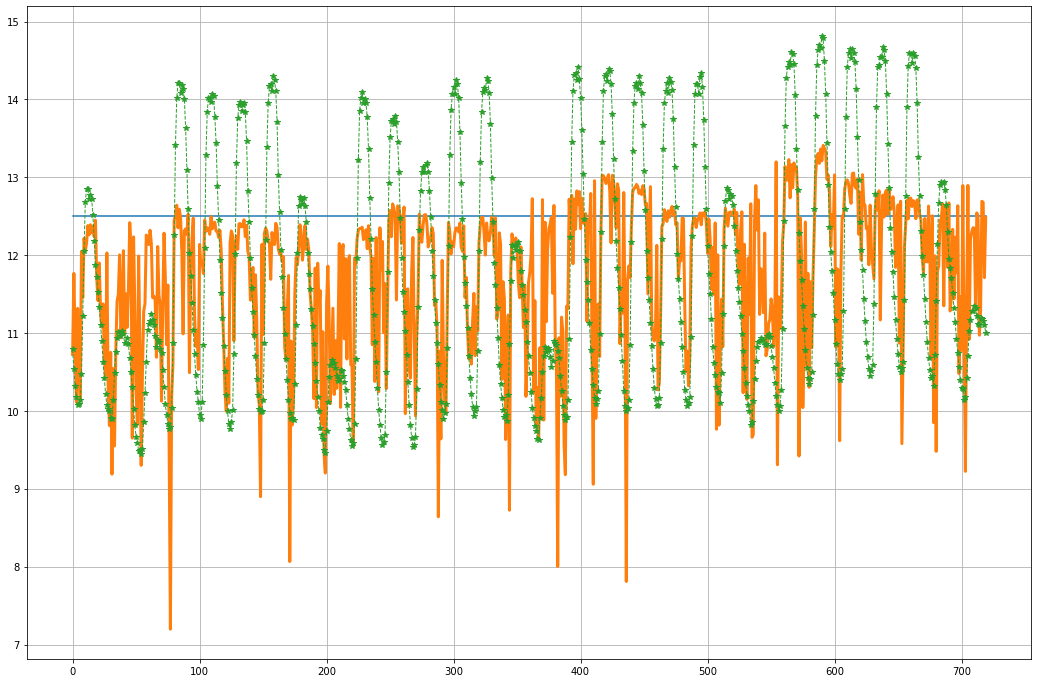

In [73]:
plt.plot([peakPowerLimit]*days*24)
plt.plot(actions.reshape(-1,)+actual[0:days*24],lw=3)
# plt.plot(actions.reshape(-1,),lw=1)
plt.plot(actual[0:days*24], '*--', lw=1)
plt.grid(True)

excess = peakPowerLimit - (actions.reshape(-1,) + actual[0:days*24])
print(np.sum(excess[np.where(excess<0)]))

excess = peakPowerLimit - (actual[0:days*24])
print(np.sum(excess[np.where(excess<0)]))


# Constrained cost arbitrage

In [ ]:
start=time.time()

for day in np.arange(0,days):
    np.random.seed(0)
    
    price = price_data#[day*24:day*24+timeHorizon]
    demand = demand_data[day*24:day*24+timeHorizon]
    
    # Define optimizer algorithm, computational budget and dimensionality of vector to be optimized
    optimizer = ng.optimizers.CMA(parametrization=timeHorizon, budget=compBudget)
    
    # Execute optimizer
    recommendation = optimizer.minimize(cost_function_arbitrage_constrained)  # best value
    
    costs[day] = cost_function_arbitrage_constrained(recommendation.value)[0]
    actions[day] = recommendation.value[0:24]
    
    batteryCharge = batteryCharge + np.cumsum(recommendation.value)[23]

    print('Time taken till day:', day, time.time() - start)
    print(batteryCharge)
    

In [ ]:
# 
price_data = list(price[0:24])*days
print(np.sum((actions.reshape(-1,) + demand_data[0:(24*days)]) * price_data))
print(np.sum((demand_data[0:(24*days)]) * price_data))

print(np.sum((actions.reshape(-1,) + demand_data[0:(24*days)]) * price_data) / np.sum((demand_data[0:(24*days)]) * price_data))

In [ ]:
plt.plot(np.cumsum(actions[0]))
plt.plot(np.cumsum(actions[1]))
plt.plot(np.cumsum(actions[2]))
# plt.plot(demand)
# plt.plot(2*price[0:48])
plt.grid(True)

In [ ]:
plt.plot(actions.reshape(-1,))
plt.plot(np.cumsum(actions.reshape(-1,)))
plt.grid(True)
plt.show()

In [ ]:
# plt.plot(actions[0])
plt.plot(demand)
plt.plot(demand+actions[0])
plt.grid(True)

In [ ]:
for i in range(days):
    plt.scatter(price[0:24],actions[i])
    plt.grid(True)
    plt.ylim(-35,35)